In [178]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

import warnings
warnings.filterwarnings('ignore')

In [179]:
df = pd.read_csv('data\data_final_preprocessed.csv')

In [189]:
df.groupby('pro_flg')['success_flg'].mean()

pro_flg
0    0.084863
1    0.073613
Name: success_flg, dtype: float64

In [181]:
df['product'].unique()

array(['Кредит', 'Кредитная карта', 'Страхование и услуги', 'Инвестиции',
       'Дебетовая карта'], dtype=object)

In [182]:
# список для хранения результатов тестирования
results = []

# Группировка данных по продуктам
for product, group in df.groupby('product'):
    contingency_table = pd.crosstab(group['bundle_nm'], group['success_flg'])

    # Проверка, достаточно ли данных для проведения теста
    if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
        # Если данных недостаточно, добавляем результат с указанием на отсутствие данных
        results.append({
            'product': product,
            'test': 'Нет данных',
            'p_value': None,
            'significant': None
        })
        continue 

    # Проверка на минимальное значение в контингентной таблице
    if contingency_table.values.min() < 5:
        # Если минимальное значение меньше 5, используем тест Фишера
        stat, p_value = stats.fisher_exact(contingency_table, alternative='two-sided')
        test_type = 'Fisher'  # Указываем тип теста
    else:
        # В противном случае используем критерий хи-квадрат
        stat, p_value, _, _ = stats.chi2_contingency(contingency_table)
        test_type = 'Chi2'  # Указываем тип теста

    # Добавление результатов теста в список
    results.append({
        'product': product,
        'test': test_type,
        'p_value': p_value,
        'significant': p_value < 0.05  # Определяем, является ли результат статистически значимым
    })

results_df = pd.DataFrame(results)

results_df


,product,test,p_value,significant
0,Дебетовая карта,Chi2,0.000013,True
1,Инвестиции,Fisher,0.009625,True
2,Кредит,Chi2,0.016884,True
3,Кредитная карта,Chi2,0.162231,False
4,Страхование и услуги,Chi2,0.402468,False


In [183]:
d = df.groupby(['product', 'pro_flg'])['success_flg'].agg(mean='mean', count='count')
d[d['count'] > 30]

mean  count
product              pro_flg                 
Дебетовая карта      0        0.300658   1367
                     1        0.477124    153
Инвестиции           0        0.051471    408
                     1        0.012500    240
Кредит               0        0.046163   1668
                     1        0.026483    944
Кредитная карта      0        0.054125   6836
                     1        0.063660   1508
Страхование и услуги 0        0.079590   1269
                     1        0.091703    687

Гипотеза подтвердилась для продуктов Debit and Investment. А для Credits и 	Insurance and Services - нет. Почему так могло произойти?\

Пользователи с подпиской Pro имеют лояльность к банку и осведомленность о его популярных пролуктах, поэтому они менее восприимчивы к предложениями о дебитовых картах и инвеситициям, ведь они и так знают про этти продукты и в случае чего сами придут к оформлению продукта

Модель для всего датасета(не по бакетам)

In [184]:
from statsmodels.genmod import families
df = pd.read_csv('data\data_final_preprocessed.csv')

for col in df['product'].unique():
    df1 = df[df['product'] == col]
    X = df1[['pro_flg', 'age', 'state_talk_time_sec']]
    y = df1['success_flg']
    X = sm.add_constant(X)
    print(f'----------------------------{col}----------------------------')
    model = sm.GLM(y, X, family=families.Binomial())
    model_result = model.fit()
    print(model_result.summary())

----------------------------Кредит----------------------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:            success_flg   No. Observations:                 2612
Model:                            GLM   Df Residuals:                     2608
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -295.42
Date:                Wed, 11 Dec 2024   Deviance:                       590.84
Time:                        23:57:15   Pearson chi2:                 1.95e+03
No. Iterations:                     8   Pseudo R-squ. (CS):            0.09844
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

In [185]:
from statsmodels.genmod import families

df = pd.read_csv('data\data_final_preprocessed.csv')
X = df[['pro_flg', 'age', 'state_talk_time_sec']]
y = df['success_flg']
X = sm.add_constant(X)

model = sm.GLM(y, X, family=families.Binomial())
model_result = model.fit()

print(model_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            success_flg   No. Observations:                15080
Model:                            GLM   Df Residuals:                    15076
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3322.5
Date:                Wed, 11 Dec 2024   Deviance:                       6645.0
Time:                        23:58:16   Pearson chi2:                 1.17e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1199
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.9463    

In [186]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df['success_flg'], model_result.predict())

np.float64(0.8619338523214619)

In [187]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

vif_data

,feature,VIF
0,const,1.309563
1,pro_flg,1.012126
2,age,1.012515
3,state_talk_time_sec,1.003632


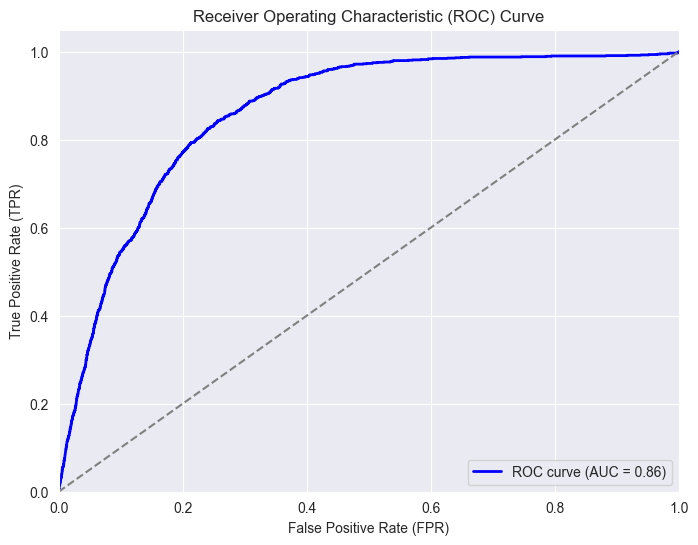

In [188]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities from the probit model
y_pred_prob = model_result.predict(X)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
